<a href="https://colab.research.google.com/github/miroorc/Capstone-Project/blob/main/Luke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade datasets

In [ ]:
pip install transformers

In [ ]:
pip install transformers[torch]

In [ ]:
#load the ecthra dataset from lex_glue
from datasets import load_dataset
ecthra = load_dataset("lex_glue", "ecthr_a")

In [ ]:
#ecthra['train']=ecthra['train'].select([10])
#ecthra['test']=ecthra['test'].select(range(10))
#ecthra['validation']=ecthra['validation'].select(range(10))

In [ ]:
#Extract the train, test, and validation parts of the ecthra dataset.
train=ecthra['train']
validation=ecthra['validation']
test=ecthra['test']

In [ ]:
#convert label to one-hot form
import numpy as np
num_classes = 10

def one_hot_encode_multi(labels, num_classes):
    encoded_labels = np.zeros((len(labels),num_classes))
    for i, sublist in enumerate(labels):
        encoded_labels[i, sublist] = 1
    return encoded_labels

In [ ]:
train_one_hot=one_hot_encode_multi(train['labels'],10)
train_one_hot = train_one_hot.tolist()
train=train.add_column(name="labels_one_hot", column=train_one_hot)

In [ ]:
test_one_hot=one_hot_encode_multi(test['labels'],10)
test_one_hot = test_one_hot.tolist()
test=test.add_column(name="labels_one_hot", column=test_one_hot)

In [ ]:
validation_one_hot=one_hot_encode_multi(validation['labels'],10)
validation_one_hot = validation_one_hot.tolist()
validation=validation.add_column(name="labels_one_hot", column=validation_one_hot)

In [ ]:
#clean the dataset to remove meaningless characters
import re
def format_text(text):
    text_format = []
    text=[[re.sub(r"^\d+\.\s*","",s) for s in sublst] for sublst in text]
    for each in text:
        text_format.append(''.join(each))
    return text_format

In [ ]:
train_text_format=format_text(train['text'])
train=train.remove_columns('text')
train=train.add_column(name="text", column=train_text_format)
ecthra['train']=train

In [ ]:
test_text_format=format_text(test['text'])
test=test.remove_columns('text')
test=test.add_column(name="text", column=test_text_format)
ecthra['test']=test

In [ ]:
validation_text_format=format_text(validation['text'])
validation=validation.remove_columns('text')
validation=validation.add_column(name="text", column=validation_text_format)
ecthra['validation']=validation

In [ ]:
ecthra=ecthra.remove_columns('labels')
ecthra=ecthra.rename_column('labels_one_hot', 'labels')

In [ ]:
from transformers import AutoTokenizer, LukeForSequenceClassification

In [ ]:
#define fine-tuning model and tokenizer


model_ckpt = "studio-ousia/luke-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, problem_type="multi_label_classification")



In [ ]:
def tokenize_and_encode(examples):
  return tokenizer(examples["text"], truncation=True)

In [ ]:
cols = ecthra["train"].column_names
cols.remove("labels")
ds_enc = ecthra.map(tokenize_and_encode, batched=True, remove_columns=cols)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
ds_enc['train']

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 9000
})

In [ ]:
len(ds_enc['train'][0]['input_ids'])

512

In [ ]:
ds_enc.set_format("torch")

In [ ]:
num_labels=10
model = LukeForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, problem_type="multi_label_classification",ignore_mismatched_sizes=True)

Some weights of LukeForSequenceClassification were not initialized from the model checkpoint at studio-ousia/luke-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)

In [ ]:
model.to('cuda')

LukeForSequenceClassification(
  (luke): LukeModel(
    (embeddings): LukeEmbeddings(
      (word_embeddings): Embedding(50267, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (entity_embeddings): LukeEntityEmbeddings(
      (entity_embeddings): Embedding(500000, 256, padding_idx=0)
      (entity_embedding_dense): Linear(in_features=256, out_features=768, bias=False)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LukeEncoder(
      (layer): ModuleList(
        (0-11): 12 x LukeLayer(
          (attention): LukeAttention(
            (self): LukeSelfAttention(
              (query): Line

In [ ]:
# define the arguments
batch_size = 4
metric_name = "f1"

args = TrainingArguments(
    f"output",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

In [ ]:
# reference: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score,recall_score
from transformers import EvalPrediction
import sklearn.metrics as skm
import torch
import json


def multi_label_metrics(predictions, labels, threshold=0.6):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    recall=recall_score(y_true, y_pred, average='macro')
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    #matrixes = skm.confusion_matrix(y_true, y_pred)
    cm = skm.multilabel_confusion_matrix(y_true, y_pred).tolist()
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'recall':recall,
               'matrixes':cm

               }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [ ]:
#define trainer
trainer = Trainer(
    model=model, args=args,
    train_dataset=ds_enc["train"],
    eval_dataset=ds_enc["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [ ]:
trainer.evaluate()

Trainer is attempting to log a value of "[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[700, 0], [300, 0]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]" of type <class 'list'> for key "eval/matrixes" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.6860754489898682,
 'eval_f1': 0.0,
 'eval_roc_auc': 0.5,
 'eval_accuracy': 0.175,
 'eval_recall': 0.0,
 'eval_matrixes': [[[943, 0], [57, 0]],
  [[807, 0], [193, 0]],
  [[813, 0], [187, 0]],
  [[700, 0], [300, 0]],
  [[913, 0], [87, 0]],
  [[996, 0], [4, 0]],
  [[958, 0], [42, 0]],
  [[967, 0], [33, 0]],
  [[982, 0], [18, 0]],
  [[861, 0], [139, 0]]],
 'eval_runtime': 35.4646,
 'eval_samples_per_second': 28.197,
 'eval_steps_per_second': 7.049}

In [ ]:
import torch
torch.cuda.empty_cache()
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Recall,Matrixes
1,0.174700,0.208563,0.458623,0.662278,0.370000,0.168532,"[[[942, 1], [48, 9]], [[792, 15], [114, 79]], [[792, 21], [110, 77]], [[587, 113], [114, 186]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[961, 6], [33, 0]], [[982, 0], [18, 0]], [[857, 4], [127, 12]]]"
2,0.149500,0.189499,0.607497,0.748552,0.486000,0.388170,"[[[941, 2], [44, 13]], [[766, 41], [73, 120]], [[778, 35], [78, 109]], [[644, 56], [126, 174]], [[888, 25], [59, 28]], [[996, 0], [3, 1]], [[931, 27], [14, 28]], [[967, 0], [30, 3]], [[982, 0], [18, 0]], [[844, 17], [64, 75]]]"
3,0.140600,0.173464,0.630786,0.764558,0.509000,0.458008,"[[[919, 24], [9, 48]], [[772, 35], [84, 109]], [[781, 32], [75, 112]], [[663, 37], [144, 156]], [[904, 9], [73, 14]], [[996, 0], [3, 1]], [[939, 19], [23, 19]], [[964, 3], [21, 12]], [[982, 0], [18, 0]], [[808, 53], [24, 115]]]"
4,0.124900,0.179513,0.658848,0.790455,0.519000,0.518202,"[[[926, 17], [15, 42]], [[760, 47], [58, 135]], [[765, 48], [53, 134]], [[640, 60], [121, 179]], [[883, 30], [58, 29]], [[993, 3], [2, 2]], [[941, 17], [21, 21]], [[966, 1], [22, 11]], [[981, 1], [16, 2]], [[830, 31], [48, 91]]]"
5,0.113500,0.180609,0.679189,0.808620,0.537000,0.571018,"[[[931, 12], [16, 41]], [[777, 30], [74, 119]], [[759, 54], [53, 134]], [[636, 64], [109, 191]], [[874, 39], [51, 36]], [[995, 1], [2, 2]], [[938, 20], [14, 28]], [[964, 3], [13, 20]], [[982, 0], [18, 0]], [[808, 53], [23, 116]]]"
6,0.094900,0.193980,0.674201,0.807422,0.522000,0.547063,"[[[927, 16], [12, 45]], [[762, 45], [60, 133]], [[770, 43], [64, 123]], [[620, 80], [107, 193]], [[872, 41], [52, 35]], [[995, 1], [4, 0]], [[936, 22], [17, 25]], [[960, 7], [5, 28]], [[981, 1], [16, 2]], [[828, 33], [37, 102]]]"
7,0.070500,0.215985,0.673913,0.805926,0.516000,0.586589,"[[[928, 15], [14, 43]], [[767, 40], [63, 130]], [[781, 32], [69, 118]], [[604, 96], [104, 196]], [[869, 44], [44, 43]], [[995, 1], [3, 1]], [[943, 15], [16, 26]], [[961, 6], [7, 26]], [[978, 4], [12, 6]], [[832, 29], [46, 93]]]"
8,0.057100,0.243907,0.674473,0.819768,0.504000,0.572677,"[[[928, 15], [14, 43]], [[742, 65], [50, 143]], [[755, 58], [49, 138]], [[575, 125], [80, 220]], [[865, 48], [53, 34]], [[996, 0], [3, 1]], [[944, 14], [19, 23]], [[963, 4], [8, 25]], [[978, 4], [15, 3]], [[839, 22], [49, 90]]]"
9,0.046900,0.250432,0.683063,0.827092,0.510000,0.583084,"[[[928, 15], [15, 42]], [[734, 73], [37, 156]], [[765, 48], [57, 130]], [[582, 118], [80, 220]], [[866, 47], [49, 38]], [[996, 0], [3, 1]], [[941, 17], [18, 24]], [[963, 4], [9, 24]], [[979, 3], [15, 3]], [[827, 34], [41, 98]]]"
10,0.032800,0.256658,0.674905,0.816226,0.503000,0.578852,"[[[926, 17], [16, 41]], [[749, 58], [49, 144]], [[774, 39], [67, 120]], [[586, 114], [82, 218]], [[865, 48], [51, 36]], [[995, 1], [3, 1]], [[942, 16], [17, 25]], [[963, 4], [9, 24]], [[977, 5], [13, 5]], [[829, 32], [43, 96]]]"


Trainer is attempting to log a value of "[[[942, 1], [48, 9]], [[792, 15], [114, 79]], [[792, 21], [110, 77]], [[587, 113], [114, 186]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[961, 6], [33, 0]], [[982, 0], [18, 0]], [[857, 4], [127, 12]]]" of type <class 'list'> for key "eval/matrixes" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[[941, 2], [44, 13]], [[766, 41], [73, 120]], [[778, 35], [78, 109]], [[644, 56], [126, 174]], [[888, 25], [59, 28]], [[996, 0], [3, 1]], [[931, 27], [14, 28]], [[967, 0], [30, 3]], [[982, 0], [18, 0]], [[844, 17], [64, 75]]]" of type <class 'list'> for key "eval/matrixes" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[[919, 24], [9, 48]], [[772, 35], [84, 109]], [[781, 32], [75, 112]], [[663, 37], [144, 156]], [[904, 9], [73, 1

TrainOutput(global_step=22500, training_loss=0.10086548139784071, metrics={'train_runtime': 10239.5417, 'train_samples_per_second': 8.789, 'train_steps_per_second': 2.197, 'total_flos': 2.960831776044691e+16, 'train_loss': 0.10086548139784071, 'epoch': 10.0})

In [ ]:
x=trainer.evaluate()

Trainer is attempting to log a value of "[[[928, 15], [15, 42]], [[734, 73], [37, 156]], [[765, 48], [57, 130]], [[582, 118], [80, 220]], [[866, 47], [49, 38]], [[996, 0], [3, 1]], [[941, 17], [18, 24]], [[963, 4], [9, 24]], [[979, 3], [15, 3]], [[827, 34], [41, 98]]]" of type <class 'list'> for key "eval/matrixes" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


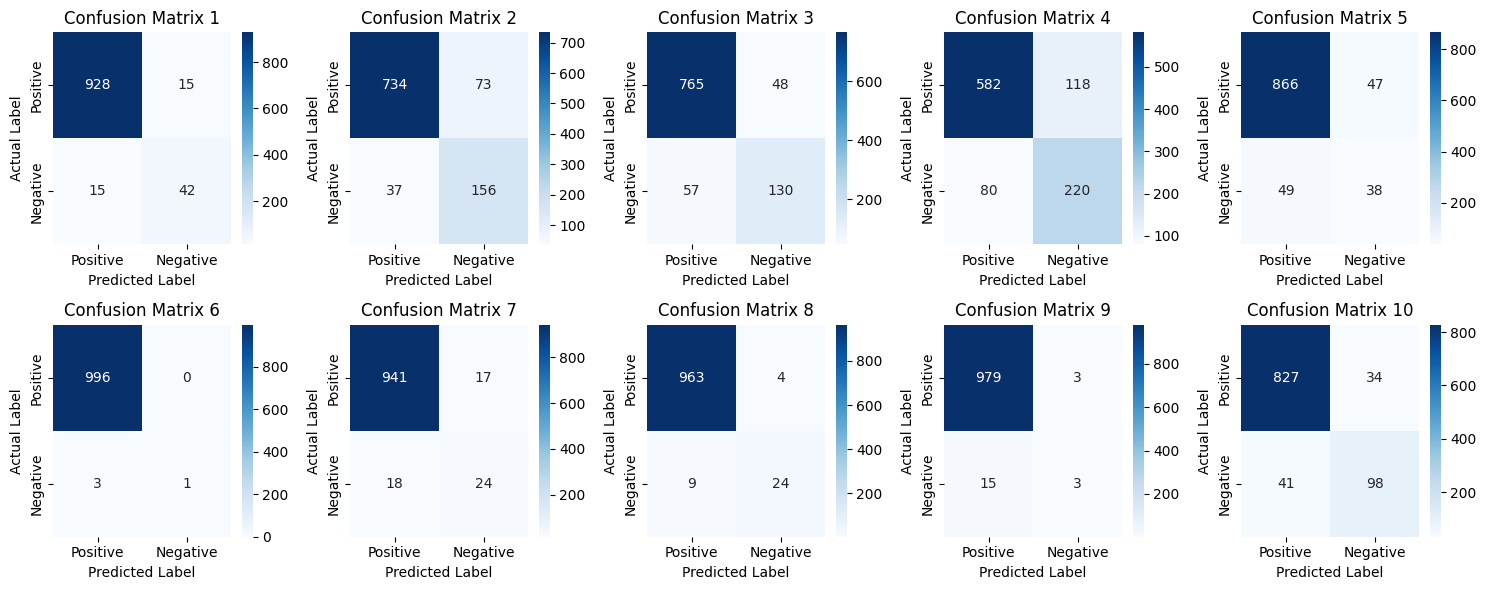

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrices = x['eval_matrixes']

labels = ['Positive', 'Negative']

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f'Confusion Matrix {i+1}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')

plt.tight_layout()
plt.show()

